# DNA metilazione, beta values e ambiente

Obiettivi del notebook:
- Capire cosa sono i **beta values** (valori di metilazione tra 0 e 1).
- Esplorare la distribuzione della metilazione in un dataset sintetico.
- Collegare metilazione e variabile di esposizione ambientale (es. PM₂.₅).
- Eseguire un'analisi molto semplice di differenza di metilazione tra gruppi.

_Tutti i dati sono simulati per fini didattici._

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

np.random.seed(42)

## Simulazione di un piccolo dataset di metilazione

Creiamo:
- 200 CpG (righe)
- 40 campioni (20 controlli, 20 esposti)
- per la maggior parte delle CpG, stessa distribuzione nei due gruppi
- per un piccolo sottoinsieme (es. 10 CpG), le medie di metilazione sono diverse tra i gruppi.

In [2]:
n_cpg = 200
n_ctrl = 20
n_exp = 20
n_samples = n_ctrl + n_exp

cpg_ids = [f"cg{str(i).zfill(6)}" for i in range(1, n_cpg + 1)]
sample_ids = [f"CTRL_{i+1}" for i in range(n_ctrl)] + [f"EXP_{i+1}" for i in range(n_exp)]

# Gruppi: 0 = controllo, 1 = esposto
group = np.array([0]*n_ctrl + [1]*n_exp)
group_series = pd.Series(group, index=sample_ids, name="group")

# Variabile di esposizione continua (es. PM2.5), più alta nel gruppo esposto
pm25_base_ctrl = 15
pm25_base_exp = 30
pm25 = np.where(group == 0,
                np.random.normal(pm25_base_ctrl, 3, size=n_samples),
                np.random.normal(pm25_base_exp, 3, size=n_samples))
pm25_series = pd.Series(pm25, index=sample_ids, name="PM25")

# Metilazione di base: beta ~ Beta(a, b)
beta_matrix = np.random.beta(a=2, b=5, size=(n_cpg, n_samples))

# Introduciamo differenze per 10 CpG "sensibili" all'esposizione
diff_cpg_idx = np.arange(0, 10)  # le prime 10 CpG
for idx in diff_cpg_idx:
    # aumento di metilazione nei soggetti esposti
    beta_matrix[idx, group == 1] += 0.2

# Limitiamo i valori a [0, 1]
beta_matrix = np.clip(beta_matrix, 0, 1)

beta_df = pd.DataFrame(beta_matrix, index=cpg_ids, columns=sample_ids)
beta_df.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,...,EXP_11,EXP_12,EXP_13,EXP_14,EXP_15,EXP_16,EXP_17,EXP_18,EXP_19,EXP_20
cg000001,0.203314,0.183877,0.367824,0.202097,0.186340,0.283520,0.100399,0.207729,0.309638,0.044386,...,0.661386,0.298321,0.379248,0.543019,0.474670,0.643295,0.332724,0.600643,0.522596,0.492362
cg000002,0.113577,0.341559,0.169996,0.801473,0.131771,0.125500,0.337014,0.034399,0.159378,0.261516,...,0.525796,0.643488,0.585567,0.296153,0.408985,0.366196,0.427215,0.675920,0.315885,0.371854
cg000003,0.240936,0.196585,0.154507,0.302475,0.262850,0.178385,0.071403,0.368048,0.165002,0.646377,...,0.259689,0.540816,0.506649,0.478956,0.528810,0.606490,0.523460,0.381343,0.310344,0.262611
cg000004,0.389374,0.220812,0.170577,0.067636,0.206369,0.358790,0.316900,0.136564,0.217084,0.136379,...,0.691610,0.384173,0.229392,0.638324,0.420199,0.327290,0.762310,0.335169,0.389265,0.478852
cg000005,0.258499,0.171362,0.390290,0.138841,0.465922,0.615752,0.307380,0.311661,0.134701,0.723903,...,0.626299,0.507657,0.286869,0.519883,0.372459,0.723608,0.344113,0.636902,0.762037,0.403881


## Esplorare la distribuzione globale dei beta values

Guardiamo la distribuzione complessiva dei beta values (tutti CpG, tutti campioni).

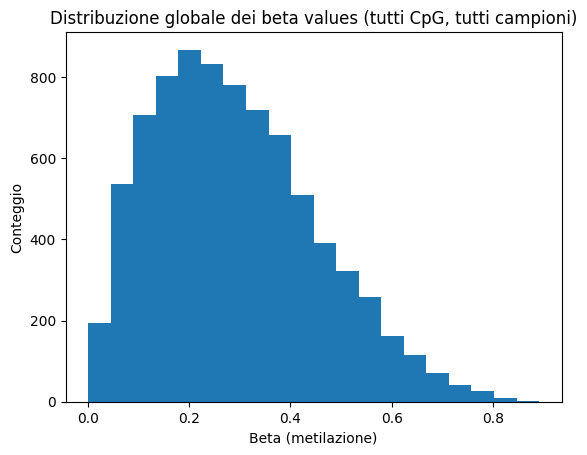

In [3]:
all_beta = beta_df.values.ravel()
plt.hist(all_beta, bins=20)
plt.xlabel("Beta (metilazione)")
plt.ylabel("Conteggio")
plt.title("Distribuzione globale dei beta values (tutti CpG, tutti campioni)")
plt.show()

## Confronto di un CpG tra controlli ed esposti

Scegliamo una CpG sensibile all'esposizione (una delle prime 10) e confrontiamo la distribuzione tra gruppi.

CpG di esempio: cg000001
Media CTRL: 0.226
Media EXP : 0.483


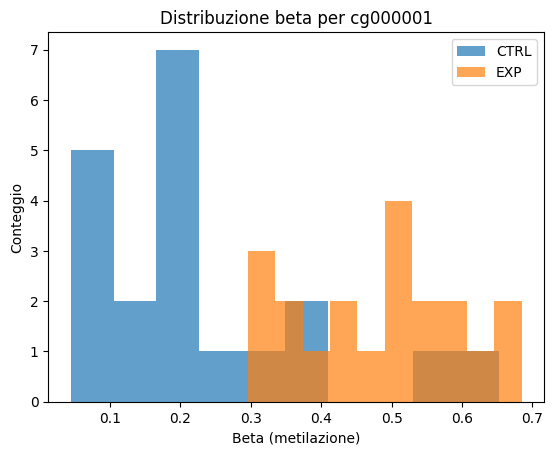

In [4]:
cpg_example = cpg_ids[0]  # una CpG con effetto
values_ctrl = beta_df.loc[cpg_example, group_series == 0]
values_exp = beta_df.loc[cpg_example, group_series == 1]

print("CpG di esempio:", cpg_example)
print("Media CTRL:", round(values_ctrl.mean(), 3))
print("Media EXP :", round(values_exp.mean(), 3))

plt.hist(values_ctrl, alpha=0.7, bins=10, label="CTRL")
plt.hist(values_exp, alpha=0.7, bins=10, label="EXP")
plt.xlabel("Beta (metilazione)")
plt.ylabel("Conteggio")
plt.title(f"Distribuzione beta per {cpg_example}")
plt.legend()
plt.show()

## Metilazione vs esposizione continua (PM₂.₅)

Per la stessa CpG, mettiamo in relazione il beta value con la concentrazione di PM₂.₅.

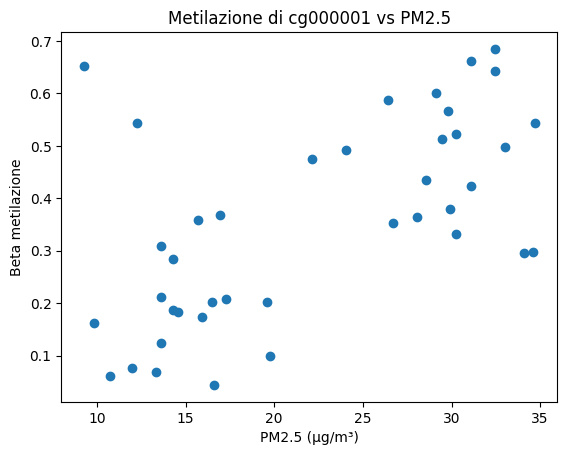

Correlazione Pearson r = 0.600, p-value = 4.331e-05


In [5]:
cpg_values = beta_df.loc[cpg_example, :]
plt.scatter(pm25_series, cpg_values)
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Beta metilazione")
plt.title(f"Metilazione di {cpg_example} vs PM2.5")
plt.show()

r, pval = stats.pearsonr(pm25_series.values, cpg_values.values)
print(f"Correlazione Pearson r = {r:.3f}, p-value = {pval:.3e}")

## Analisi semplice di differenza di metilazione (DMC)

Eseguiamo, per ogni CpG:
- la differenza di media (EXP - CTRL)
- un t-test di Student tra gruppi

_Nota_: è un esempio didattico; nelle analisi reali bisogna usare modelli più robusti, correzioni multiple, ecc.

In [6]:
results = []
for cpg in cpg_ids:
    vals = beta_df.loc[cpg, :]
    vals_ctrl = vals[group_series == 0]
    vals_exp = vals[group_series == 1]
    diff = vals_exp.mean() - vals_ctrl.mean()
    tstat, pval = stats.ttest_ind(vals_exp, vals_ctrl, equal_var=False)
    results.append({
        "CpG": cpg,
        "mean_ctrl": vals_ctrl.mean(),
        "mean_exp": vals_exp.mean(),
        "diff_exp_minus_ctrl": diff,
        "pval": pval,
    })

res_df = pd.DataFrame(results).set_index("CpG")
res_df_sorted = res_df.sort_values("pval")
res_df_sorted.head(10)

,mean_ctrl,mean_exp,diff_exp_minus_ctrl,pval
CpG,,,,
cg000001,0.226161,0.483495,0.257334,0.000001
cg000006,0.279962,0.515150,0.235187,0.000005
cg000008,0.329511,0.557693,0.228182,0.000091
cg000002,0.237131,0.453850,0.216719,0.000133
cg000007,0.274914,0.453118,0.178204,0.000288
cg000004,0.275874,0.481245,0.205371,0.000307
cg000009,0.298556,0.495361,0.196806,0.000345
cg000036,0.197503,0.352040,0.154537,0.000757
cg000131,0.313533,0.188330,-0.125203,0.000832


## Selezionare CpG potenzialmente differenzialmente metilate

Applichiamo una soglia molto semplice:
- |diff| ≥ 0.1
- p-value ≤ 0.01

_Solo per scopi illustrativi._

In [7]:
threshold_diff = 0.1
threshold_p = 0.01

hits = res_df[(res_df["diff_exp_minus_ctrl"].abs() >= threshold_diff) & (res_df["pval"] <= threshold_p)]
print(f"Numero di CpG che passano le soglie: {len(hits)}")
hits.sort_values("pval").head(10)

Numero di CpG che passano le soglie: 14


,mean_ctrl,mean_exp,diff_exp_minus_ctrl,pval
CpG,,,,
cg000001,0.226161,0.483495,0.257334,0.000001
cg000006,0.279962,0.515150,0.235187,0.000005
cg000008,0.329511,0.557693,0.228182,0.000091
cg000002,0.237131,0.453850,0.216719,0.000133
cg000007,0.274914,0.453118,0.178204,0.000288
cg000004,0.275874,0.481245,0.205371,0.000307
cg000009,0.298556,0.495361,0.196806,0.000345
cg000036,0.197503,0.352040,0.154537,0.000757
cg000131,0.313533,0.188330,-0.125203,0.000832


Questa è un'analisi estremamente semplificata, ma illustra il concetto di **DMC** (Differentially Methylated CpG) in un contesto esposizione vs controllo.

In studi reali di epigenomica ambientale si lavora spesso con:
- centinaia di migliaia di CpG (array 450k/EPIC)
- modelli lineari (es. limma) con covariate (età, sesso, cell composition, batch)
- correzione per test multipli (FDR).

Qui però abbiamo visto i mattoncini di base in Python.